Importing libraries

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import klib

import openaq
from IPython.core.display import display

# pd.set_option('max_columns', None)
# pd.reset_optio('max_rows')
#np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

#Load data

In [80]:
daily_aqi_by_county_2017 = pd.read_csv('../../data/raw/daily_aqi_by_county_2017.csv', encoding='latin-1')
daily_aqi_by_county_2018 = pd.read_csv('../../data/raw/daily_aqi_by_county_2018.csv')
daily_aqi_by_county_2019 = pd.read_csv('../../data/raw/daily_aqi_by_county_2019.csv')

annual_income_by_county = pd.read_csv('../../data/raw/CAINC1__ALL_AREAS_1969_2019.csv', encoding='latin-1')

county_demographic = pd.read_csv('../../data/raw/county_cc-est2019-alldata.csv', encoding='latin-1')



# Clean annual personal income by county

Remove columns we do not need and rows not needed

In [81]:
def remove_col(df, col_name):
    '''Returns a dataframe with removed column or columns from old dataframe'''
    new_df = df.copy()

    if(type(col_name) != str and len(col_name) > 1):
        for index in col_name:
            new_df = new_df.drop(str(index), axis=1)
    else:
        new_df = new_df.drop(str(col_name), axis=1)
    return new_df

all_incomes_2017_2019 = remove_col(annual_income_by_county, range(1969, 2017))

# used to remove last 4 rows as they are not index data; looks like extra info
all_incomes_2017_2019 = all_incomes_2017_2019[:len(all_incomes_2017_2019) - 4]

# all_incomes_2017_2019.info()
all_incomes_2017_2019

,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,2017,2018,2019
0,"""00000""",United States,,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,16937582000,17839255000,18542262000
1,"""00000""",United States,,CAINC1,2.0,...,Population (persons) 1/,Number of persons,324985539,326687501,328239523
2,"""00000""",United States,,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,52118,54606,56490
3,"""01000""",Alabama,5,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,199999756,208752683,216449038
4,"""01000""",Alabama,5,CAINC1,2.0,...,Population (persons) 1/,Number of persons,4874486,4887681,4903185
...,...,...,...,...,...,...,...,...,...,...,...
9589,"""97000""",Rocky Mountain,7,CAINC1,2.0,...,Population (persons) 1/,Number of persons,12062055,12233639,12399296
9590,"""97000""",Rocky Mountain,7,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,49991,52936,54873
9591,"""98000""",Far West,8,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,3279057722,3472097346,3634009401
9592,"""98000""",Far West,8,CAINC1,2.0,...,Population (persons) 1/,Number of persons,56059482,56350416,56572426


* Years 1969 to 2016 were removed as we only have interest on 2017-2019
* Also last four rows were remoed as they were not row data, there were just caption text

In [82]:

all_incomes_2017_2019['Year 2017 (thousands of dollars)'] = pd.to_numeric(all_incomes_2017_2019['2017'], downcast='float', errors='coerce')
all_incomes_2017_2019['Year 2018 (thousands of dollars)'] = pd.to_numeric(all_incomes_2017_2019['2018'], downcast='float', errors='coerce')
all_incomes_2017_2019['Year 2019 (thousands of dollars)'] = pd.to_numeric(all_incomes_2017_2019['2019'], downcast='float', errors='coerce')

all_incomes_2017_2019 = remove_col(all_incomes_2017_2019, range(2017,2020))
all_incomes_2017_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9594 entries, 0 to 9593
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   GeoFIPS                           9594 non-null   object 
 1   GeoName                           9594 non-null   object 
 2   Region                            9594 non-null   object 
 3   TableName                         9594 non-null   object 
 4   LineCode                          9594 non-null   float64
 5   IndustryClassification            9594 non-null   object 
 6   Description                       9594 non-null   object 
 7   Unit                              9594 non-null   object 
 8   Year 2017 (thousands of dollars)  9519 non-null   float32
 9   Year 2018 (thousands of dollars)  9519 non-null   float32
 10  Year 2019 (thousands of dollars)  9519 non-null   float32
dtypes: float32(3), float64(1), object(7)
memory usage: 712.2+ KB


* Columns were changed to appropriate types
* Income was changed to type float
* 'NA' string was changed to np.nan
* Rename column income data to be more descriptive and remove old column in place of new column names

In [83]:
personal_income = all_incomes_2017_2019['Description'] == ('Personal income (thousands of dollars)')
county_personal_incomes_2017_2019 = all_incomes_2017_2019[personal_income]
county_personal_incomes_2017_2019.head()

cols_to_remove = ['IndustryClassification', 'TableName', 'Unit', 'Description', 'LineCode']
# county_personal_incomes_2017_2019 = remove_col(personal_income, cols_to_remove)
county_personal_incomes_2017_2019
county_personal_incomes_2017_2019 = remove_col(county_personal_incomes_2017_2019, cols_to_remove)
county_personal_incomes_2017_2019


,GeoFIPS,GeoName,Region,Year 2017 (thousands of dollars),Year 2018 (thousands of dollars),Year 2019 (thousands of dollars)
0,"""00000""",United States,,1.693758e+10,1.783926e+10,1.854226e+10
3,"""01000""",Alabama,5,1.999998e+08,2.087527e+08,2.164490e+08
6,"""01001""","Autauga, AL",5,2.276561e+06,2.360366e+06,2.453617e+06
9,"""01003""","Baldwin, AL",5,9.471242e+06,1.006597e+07,1.060026e+07
12,"""01005""","Barbour, AL",5,8.381840e+05,8.721890e+05,8.828340e+05
...,...,...,...,...,...,...
9579,"""94000""",Plains,4,1.055029e+09,1.107630e+09,1.146515e+09
9582,"""95000""",Southeast,5,3.818755e+09,4.022276e+09,4.173677e+09
9585,"""96000""",Southwest,6,1.924648e+09,2.051027e+09,2.144764e+09
9588,"""97000""",Rocky Mountain,7,6.029942e+08,6.476007e+08,6.803901e+08


Removed redundant or uninterested columns
* remove more columns
* remove IndustryClassifaction as it only contains ... values and also not what we are interested in
* remove TableName as only one value and not what we are interested in
* remove Unit as that has the same value as Thousands of dollars
* remove Description as that is all personal income now
* remove LineCode as there are no unique values all value is 1


# Clean AQI pollution

Combine the aqi pollution years together

In [84]:
county_daily_aqi_by_2017_2019 = pd.concat([daily_aqi_by_county_2017, daily_aqi_by_county_2018, daily_aqi_by_county_2019], axis=0)

county_daily_aqi_by_2017_2019

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1
...,...,...,...,...,...,...,...,...,...,...
341940,Wyoming,Weston,56,45,2019-12-27,36,Good,Ozone,56-045-0003,2
341941,Wyoming,Weston,56,45,2019-12-28,37,Good,Ozone,56-045-0003,2
341942,Wyoming,Weston,56,45,2019-12-29,34,Good,Ozone,56-045-0003,2
341943,Wyoming,Weston,56,45,2019-12-30,36,Good,Ozone,56-045-0003,2


* aqi year 2017 to 2019 were concatenated

In [85]:
type(county_daily_aqi_by_2017_2019.Date.values[1])
county_daily_aqi_by_2017_2019.Date = pd.to_datetime(county_daily_aqi_by_2017_2019.Date)
type(county_daily_aqi_by_2017_2019.Date.values[1])

numpy.datetime64

* Date column was changed to datetime type object

# Clean demographic data


In [86]:
year_2017_2019 = county_demographic['YEAR'] > 9
county_demographic_2017_2019 = county_demographic.loc[year_2017_2019]
county_demographic_2017_2019 = county_demographic_2017_2019.reset_index(drop=True)
county_demographic_2017_2019 = remove_col(county_demographic_2017_2019, 'SUMLEV')
county_demographic_2017_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179094 entries, 0 to 179093
Data columns (total 79 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   STATE         179094 non-null  int64 
 1   COUNTY        179094 non-null  int64 
 2   STNAME        179094 non-null  object
 3   CTYNAME       179094 non-null  object
 4   YEAR          179094 non-null  int64 
 5   AGEGRP        179094 non-null  int64 
 6   TOT_POP       179094 non-null  int64 
 7   TOT_MALE      179094 non-null  int64 
 8   TOT_FEMALE    179094 non-null  int64 
 9   WA_MALE       179094 non-null  int64 
 10  WA_FEMALE     179094 non-null  int64 
 11  BA_MALE       179094 non-null  int64 
 12  BA_FEMALE     179094 non-null  int64 
 13  IA_MALE       179094 non-null  int64 
 14  IA_FEMALE     179094 non-null  int64 
 15  AA_MALE       179094 non-null  int64 
 16  AA_FEMALE     179094 non-null  int64 
 17  NA_MALE       179094 non-null  int64 
 18  NA_FEMALE     179094 non

* (clean up on years interested and age group interested in)
* (check if column types are appropriate)
* (remove sumlev col as it just indicates that we are using county level or equivalent)

In [87]:
total = county_demographic_2017_2019.AGEGRP == 0
county_demographic_2017_2019 = county_demographic_2017_2019.loc[total]
county_demographic_2017_2019 = remove_col(county_demographic_2017_2019, 'AGEGRP')


* reduce rows by having a reducing age group to totals
* maybe try binning age groups from 1-12 (0-59) and 13-19 (60+)


In [88]:
ethnicities = list(county_demographic_2017_2019.iloc[:, 20:29])
ethnicities.extend(list(county_demographic_2017_2019.iloc[:, 32:54]))
ethnicities.extend(list(county_demographic_2017_2019.iloc[:, 56:]))
county_demographic_2017_2019 = remove_col(county_demographic_2017_2019, ethnicities)

# can add columns

* Reduced ethnicity columns and removed irrelevant columns

In [89]:
display(county_demographic_2017_2019)


,STATE,COUNTY,STNAME,CTYNAME,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,...,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,NAC_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE
0,1,1,Alabama,Autauga County,10,55390,27010,28380,20876,21705,...,385,30,26,561,481,55,26188,27643,822,737
19,1,1,Alabama,Autauga County,11,55533,27006,28527,20917,21749,...,374,33,28,535,494,58,26140,27771,866,756
38,1,1,Alabama,Autauga County,12,55869,27092,28777,20878,21729,...,370,32,26,538,507,49,26208,27990,884,787
57,1,3,Alabama,Baldwin County,10,212521,103218,109303,90360,95215,...,1361,69,69,1785,1913,168,98087,104753,5131,4550
76,1,3,Alabama,Baldwin County,11,217855,105702,112153,92613,97815,...,1396,70,72,1897,1984,176,100355,107363,5347,4790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178999,56,43,Wyoming,Washakie County,11,7877,3984,3893,3781,3670,...,37,5,3,86,90,8,3416,3352,568,541
179018,56,43,Wyoming,Washakie County,12,7805,3963,3842,3759,3618,...,39,4,2,87,89,11,3398,3299,565,543
179037,56,45,Wyoming,Weston County,10,6968,3660,3308,3447,3111,...,63,2,0,78,75,7,3501,3180,159,128
179056,56,45,Wyoming,Weston County,11,6924,3627,3297,3401,3073,...,74,2,0,83,84,3,3475,3176,152,121


# Combine the three separate dataframes
Attempt to combine dataframe through creating foreign key, GeoFIPs

In [90]:
display(county_demographic_2017_2019)
display(county_personal_incomes_2017_2019)
display(county_daily_aqi_by_2017_2019)
# print(county_demographic_2017_2019.loc[county_demographic_2017_2019.COUNTY == 3])
# make a foreign key to link them all up

,STATE,COUNTY,STNAME,CTYNAME,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,...,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,NAC_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE
0,1,1,Alabama,Autauga County,10,55390,27010,28380,20876,21705,...,385,30,26,561,481,55,26188,27643,822,737
19,1,1,Alabama,Autauga County,11,55533,27006,28527,20917,21749,...,374,33,28,535,494,58,26140,27771,866,756
38,1,1,Alabama,Autauga County,12,55869,27092,28777,20878,21729,...,370,32,26,538,507,49,26208,27990,884,787
57,1,3,Alabama,Baldwin County,10,212521,103218,109303,90360,95215,...,1361,69,69,1785,1913,168,98087,104753,5131,4550
76,1,3,Alabama,Baldwin County,11,217855,105702,112153,92613,97815,...,1396,70,72,1897,1984,176,100355,107363,5347,4790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178999,56,43,Wyoming,Washakie County,11,7877,3984,3893,3781,3670,...,37,5,3,86,90,8,3416,3352,568,541
179018,56,43,Wyoming,Washakie County,12,7805,3963,3842,3759,3618,...,39,4,2,87,89,11,3398,3299,565,543
179037,56,45,Wyoming,Weston County,10,6968,3660,3308,3447,3111,...,63,2,0,78,75,7,3501,3180,159,128
179056,56,45,Wyoming,Weston County,11,6924,3627,3297,3401,3073,...,74,2,0,83,84,3,3475,3176,152,121


,GeoFIPS,GeoName,Region,Year 2017 (thousands of dollars),Year 2018 (thousands of dollars),Year 2019 (thousands of dollars)
0,"""00000""",United States,,1.693758e+10,1.783926e+10,1.854226e+10
3,"""01000""",Alabama,5,1.999998e+08,2.087527e+08,2.164490e+08
6,"""01001""","Autauga, AL",5,2.276561e+06,2.360366e+06,2.453617e+06
9,"""01003""","Baldwin, AL",5,9.471242e+06,1.006597e+07,1.060026e+07
12,"""01005""","Barbour, AL",5,8.381840e+05,8.721890e+05,8.828340e+05
...,...,...,...,...,...,...
9579,"""94000""",Plains,4,1.055029e+09,1.107630e+09,1.146515e+09
9582,"""95000""",Southeast,5,3.818755e+09,4.022276e+09,4.173677e+09
9585,"""96000""",Southwest,6,1.924648e+09,2.051027e+09,2.144764e+09
9588,"""97000""",Rocky Mountain,7,6.029942e+08,6.476007e+08,6.803901e+08


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1
...,...,...,...,...,...,...,...,...,...,...
341940,Wyoming,Weston,56,45,2019-12-27,36,Good,Ozone,56-045-0003,2
341941,Wyoming,Weston,56,45,2019-12-28,37,Good,Ozone,56-045-0003,2
341942,Wyoming,Weston,56,45,2019-12-29,34,Good,Ozone,56-045-0003,2
341943,Wyoming,Weston,56,45,2019-12-30,36,Good,Ozone,56-045-0003,2


In [91]:
# need to make a foreign key for ethnicity and aqi
state_dem = county_demographic_2017_2019.STATE.astype(str).values
county_dem = county_demographic_2017_2019.COUNTY.astype(str).values
geofips_dem = []
for stateID, countyID in zip(state_dem, county_dem):
    id = ''
    stateLen = len(stateID)
    countyLen = len(countyID)
    if(stateLen < 2):
        id += '0' + stateID
    else:
        id += stateID
    if(countyLen == 1):
        id += '00' + countyID
    elif(countyLen == 2):
        id += '0' + countyID
    else:
        id += countyID
    geofips_dem.append(id)

county_demographic_2017_2019['GeoFIPS'] = geofips_dem
county_demographic_2017_2019

,STATE,COUNTY,STNAME,CTYNAME,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,...,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,NAC_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE,GeoFIPS
0,1,1,Alabama,Autauga County,10,55390,27010,28380,20876,21705,...,30,26,561,481,55,26188,27643,822,737,01001
19,1,1,Alabama,Autauga County,11,55533,27006,28527,20917,21749,...,33,28,535,494,58,26140,27771,866,756,01001
38,1,1,Alabama,Autauga County,12,55869,27092,28777,20878,21729,...,32,26,538,507,49,26208,27990,884,787,01001
57,1,3,Alabama,Baldwin County,10,212521,103218,109303,90360,95215,...,69,69,1785,1913,168,98087,104753,5131,4550,01003
76,1,3,Alabama,Baldwin County,11,217855,105702,112153,92613,97815,...,70,72,1897,1984,176,100355,107363,5347,4790,01003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178999,56,43,Wyoming,Washakie County,11,7877,3984,3893,3781,3670,...,5,3,86,90,8,3416,3352,568,541,56043
179018,56,43,Wyoming,Washakie County,12,7805,3963,3842,3759,3618,...,4,2,87,89,11,3398,3299,565,543,56043
179037,56,45,Wyoming,Weston County,10,6968,3660,3308,3447,3111,...,2,0,78,75,7,3501,3180,159,128,56045
179056,56,45,Wyoming,Weston County,11,6924,3627,3297,3401,3073,...,2,0,83,84,3,3475,3176,152,121,56045


In [92]:
#repeat for aqi
state_aqi = county_daily_aqi_by_2017_2019['State Code'].astype(str).values
county_aqi = county_daily_aqi_by_2017_2019['County Code'].astype(str).values

geofips_aqi = []
for stateID, countyID in zip(state_aqi, county_aqi):
    id = ''
    stateLen = len(stateID)
    countyLen = len(countyID)
    if(stateLen < 2):
        id += '0' + stateID
    else:
        id += stateID
    if(countyLen == 1):
        id += '00' + countyID
    elif(countyLen == 2):
        id += '0' + countyID
    else:
        id += countyID
    geofips_aqi.append(id)

county_daily_aqi_by_2017_2019['GeoFIPS'] = geofips_aqi
county_daily_aqi_by_2017_2019

# pd.set_option('display.max_rows', 1000)
# county_personal_incomes_2017_2019

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,GeoFIPS
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1,01003
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1,01003
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1,01003
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1,01003
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1,01003
...,...,...,...,...,...,...,...,...,...,...,...
341940,Wyoming,Weston,56,45,2019-12-27,36,Good,Ozone,56-045-0003,2,56045
341941,Wyoming,Weston,56,45,2019-12-28,37,Good,Ozone,56-045-0003,2,56045
341942,Wyoming,Weston,56,45,2019-12-29,34,Good,Ozone,56-045-0003,2,56045
341943,Wyoming,Weston,56,45,2019-12-30,36,Good,Ozone,56-045-0003,2,56045


In [93]:
# remove "" characters from income dataset
county_personal_incomes_2017_2019['temp'] = county_personal_incomes_2017_2019.GeoFIPS.str.strip('" "')
county_personal_incomes_2017_2019.GeoFIPS = county_personal_incomes_2017_2019.temp
county_personal_incomes_2017_2019 = remove_col(county_personal_incomes_2017_2019, 'temp')
county_personal_incomes_2017_2019

,GeoFIPS,GeoName,Region,Year 2017 (thousands of dollars),Year 2018 (thousands of dollars),Year 2019 (thousands of dollars)
0,00000,United States,,1.693758e+10,1.783926e+10,1.854226e+10
3,01000,Alabama,5,1.999998e+08,2.087527e+08,2.164490e+08
6,01001,"Autauga, AL",5,2.276561e+06,2.360366e+06,2.453617e+06
9,01003,"Baldwin, AL",5,9.471242e+06,1.006597e+07,1.060026e+07
12,01005,"Barbour, AL",5,8.381840e+05,8.721890e+05,8.828340e+05
...,...,...,...,...,...,...
9579,94000,Plains,4,1.055029e+09,1.107630e+09,1.146515e+09
9582,95000,Southeast,5,3.818755e+09,4.022276e+09,4.173677e+09
9585,96000,Southwest,6,1.924648e+09,2.051027e+09,2.144764e+09
9588,97000,Rocky Mountain,7,6.029942e+08,6.476007e+08,6.803901e+08


# Backtrack: Check for missing data
Check for any missing data or other areas before merginng the datasets

No missing values found in the dataset.
No missing values found in the dataset.


GridSpec(6, 6)

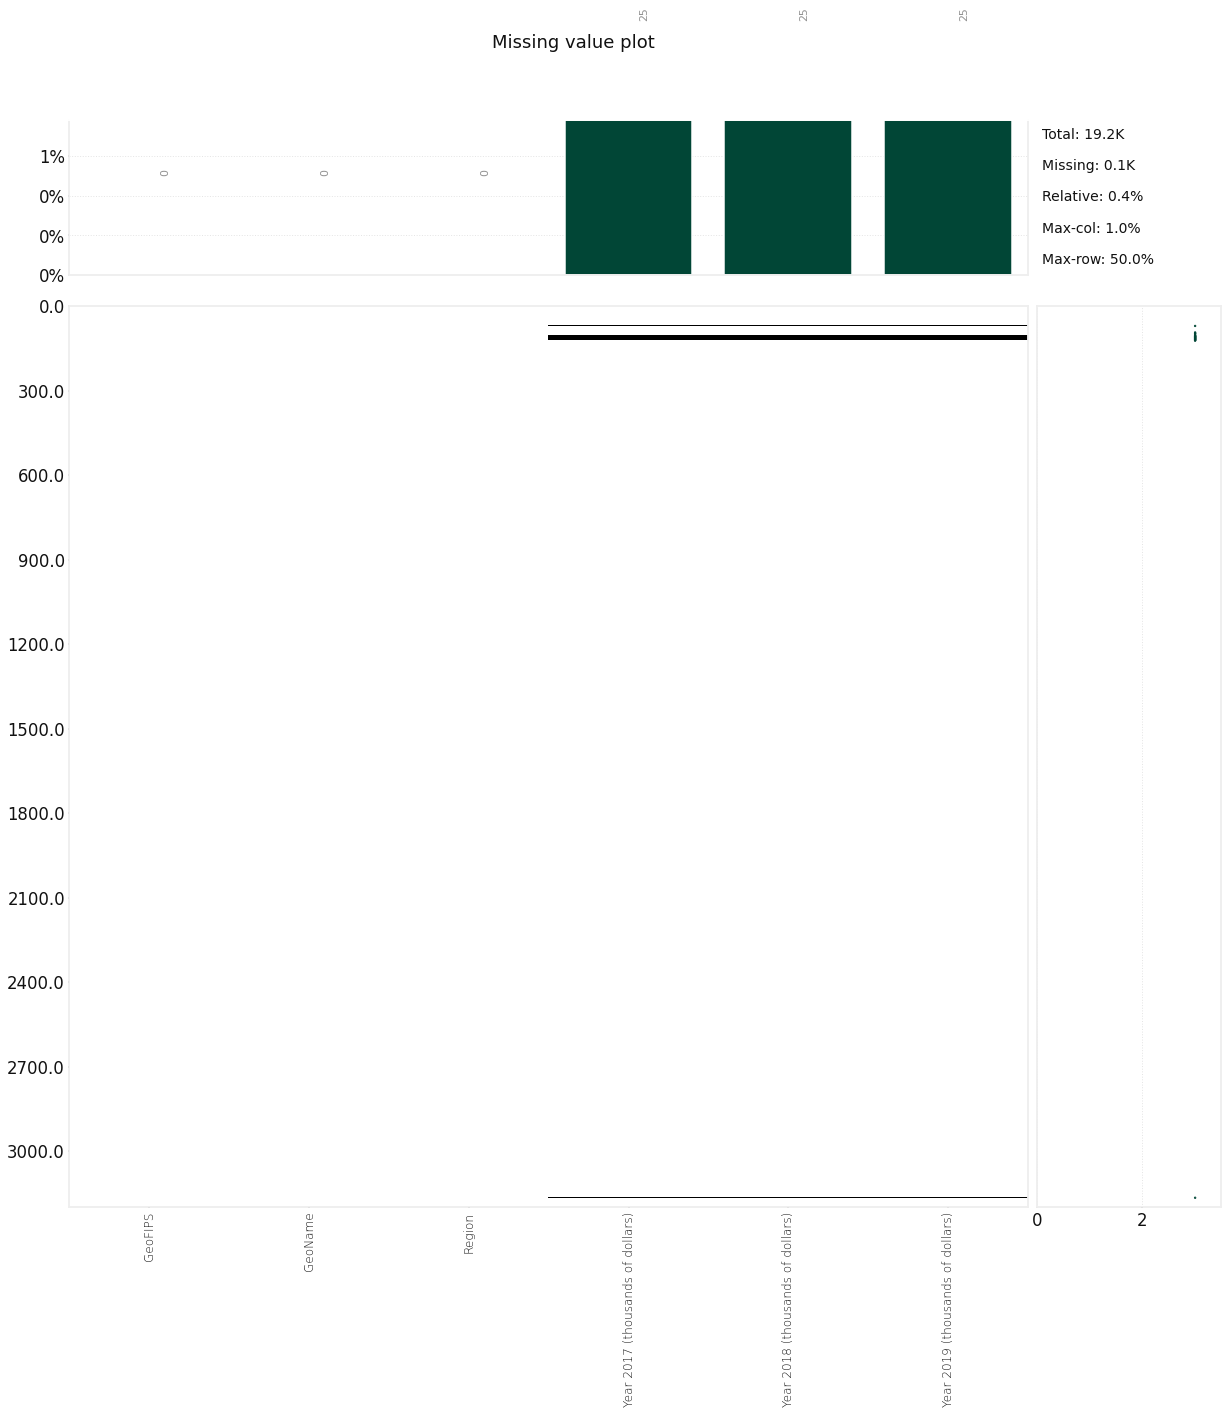

In [94]:
# use klib for missing data
# display(county_demographic_2017_2019.isnull().sum())
# display(county_daily_aqi_by_2017_2019.isnull().sum())
# display(county_personal_incomes_2017_2019.isnull().sum())
klib.missingval_plot(county_daily_aqi_by_2017_2019)
klib.missingval_plot(county_demographic_2017_2019)
klib.missingval_plot(county_personal_incomes_2017_2019)

In [95]:
# missing data in personal income

missing = county_personal_incomes_2017_2019['Year 2017 (thousands of dollars)'].isnull()
display(county_personal_incomes_2017_2019.loc[missing])
missing_id = county_personal_incomes_2017_2019.loc[missing]['GeoFIPS'].values
# missing data mainly in AK and one in Wisconsin
# doesnt really to matter much as they are not found in other dataset and cannot be merge

,GeoFIPS,GeoName,Region,Year 2017 (thousands of dollars),Year 2018 (thousands of dollars),Year 2019 (thousands of dollars)
210,02010,"Aleutian Islands Census Area, AK*",8,NaN,NaN,NaN
279,02201,"Prince of Wales-Outer Ketchikan Census Area, AK*",8,NaN,NaN,NaN
288,02231,"Skagway-Yakutat-Angoon Census Area, AK*",8,NaN,NaN,NaN
291,02232,"Skagway-Hoonah-Angoon Census Area, AK*",8,NaN,NaN,NaN
303,02280,"Wrangell-Petersburg Census Area, AK*",8,NaN,NaN,NaN
312,02901,"Aleutian Islands Division, AK*",8,NaN,NaN,NaN
315,02903,"Angoon Division, AK*",8,NaN,NaN,NaN
318,02904,"Barrow-North Slope Division, AK*",8,NaN,NaN,NaN
321,02905,"Bethel Division, AK*",8,NaN,NaN,NaN
324,02907,"Bristol Bay Division, AK*",8,NaN,NaN,NaN


In [96]:
#inspect missing data from other datasets

for id in missing_id:
    display(id in county_daily_aqi_by_2017_2019['GeoFIPS'])
    display(id in county_demographic_2017_2019['GeoFIPS'])

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

In [97]:
# use klib for further cleaning

# Merge income, ethnicity, aqi dataframes
Missing data for these counties are not found in the other datasets; and will be removed when merged
Means our dataset will not have any missing data

In [98]:
# merge dataframes by geofips
# merge income and ethnicity
county_income_ethnicity_2017_2019 = pd.merge(county_personal_incomes_2017_2019, county_demographic_2017_2019, on='GeoFIPS')

In [99]:
df = pd.merge(county_income_ethnicity_2017_2019, county_daily_aqi_by_2017_2019, on='GeoFIPS')

In [100]:
# need to remove dupe columns

cols_to_remove = ['GeoName', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'State Code', 'County Code']
df = remove_col(df, cols_to_remove)

In [101]:
print(df.columns)

df = df[['GeoFIPS', 'Region', 'State Name', 'county Name', 'Year 2017 (thousands of dollars)',
       'Year 2018 (thousands of dollars)', 'Year 2019 (thousands of dollars)',
       'YEAR', 'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE',
       'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE',
       'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'NAC_FEMALE',
       'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE', 'Date', 'AQI', 'Category', 'Defining Parameter',
       'Defining Site', 'Number of Sites Reporting']]


Index(['GeoFIPS', 'Region', 'Year 2017 (thousands of dollars)',
       'Year 2018 (thousands of dollars)', 'Year 2019 (thousands of dollars)',
       'YEAR', 'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE',
       'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE',
       'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'NAC_FEMALE',
       'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE', 'State Name',
       'county Name', 'Date', 'AQI', 'Category', 'Defining Parameter',
       'Defining Site', 'Number of Sites Reporting'],
      dtype='object')


Reduce memory usage with klib


In [102]:
df_cleaned = klib.data_cleaning(df)
# df.isnull().sum()
# AK = df['State Name'] == 'Arkansas'
# df.head()

# over = df_cleaned.aqi > 3000
# df_cleaned.loc[over]

Long column names detected (>25 characters). Consider renaming the following columns ['year_2017_thousands_of_dollars', 'year_2018_thousands_of_dollars', 'year_2019_thousands_of_dollars'].
Shape of cleaned data: (3019590, 34)Remaining NAs: 0

Changes:
Dropped rows: 0
     of which 0 duplicates. (Rows: [])
Dropped columns: 0
     of which 0 single valued.     Columns: []
Dropped missing values: 0
Reduced memory by at least: 340.24 MB (-44.09%)



<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

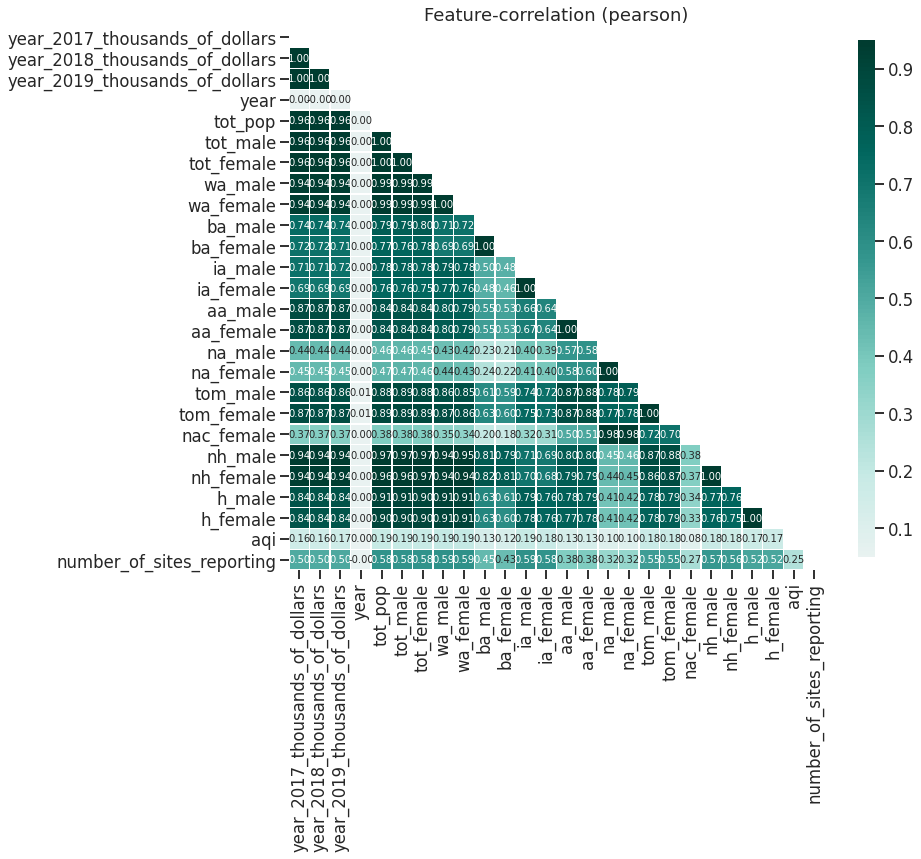

In [103]:
# see correlations with klib

klib.corr_plot(df_cleaned)

this is not that good as it seems that our features show very weak correlations with influencing aqi
* will try this correlation run with ratio of ethnicities
* seems that personal income of counties does not influence aqi

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

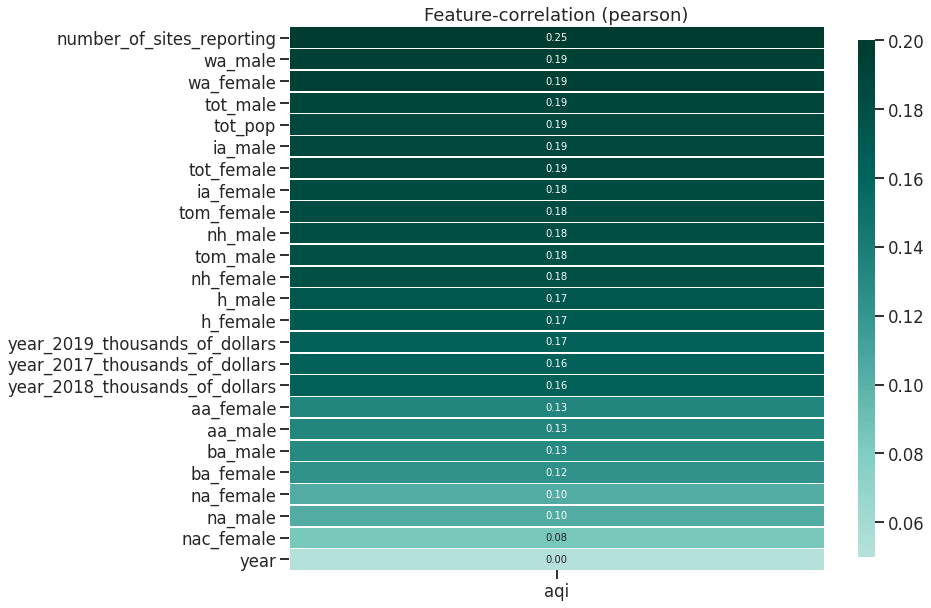

In [105]:
df_cleaned.columns
klib.corr_plot(df_cleaned, target='aqi')



In [106]:
print(county_daily_aqi_by_2017_2019.Category.unique())

good_df = df_cleaned.loc[df_cleaned.category == 'Good']
moderate_df = df_cleaned.loc[df_cleaned.category == 'Moderate']
unhealthy_for_sensitive_df = df_cleaned.loc[df_cleaned.category == 'Unhealthy for Sensitive Groups']
unhealthy_df = df_cleaned.loc[df_cleaned.category == 'Unhealthy']
very_unhealthy_df = df_cleaned.loc[df_cleaned.category == 'Very Unhealthy']
hazardous_df = df_cleaned.loc[df_cleaned.category == 'Hazardous']

['Good' 'Moderate' 'Unhealthy for Sensitive Groups' 'Unhealthy'
 'Very Unhealthy' 'Hazardous']


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

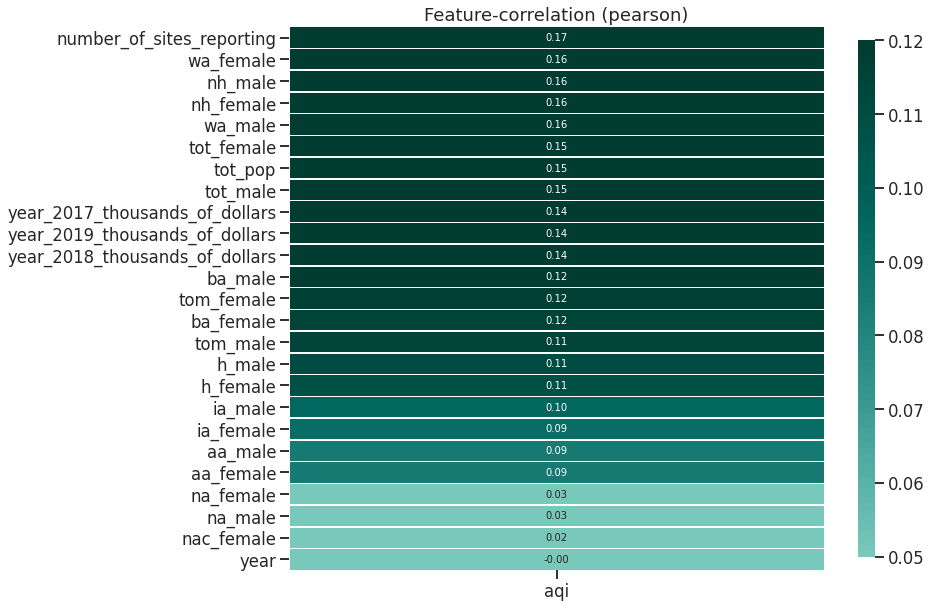

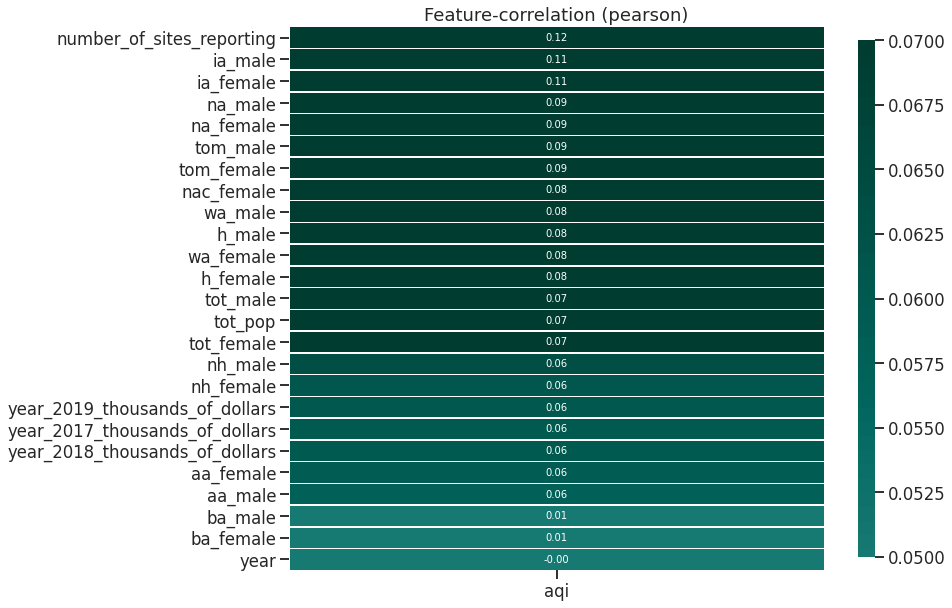

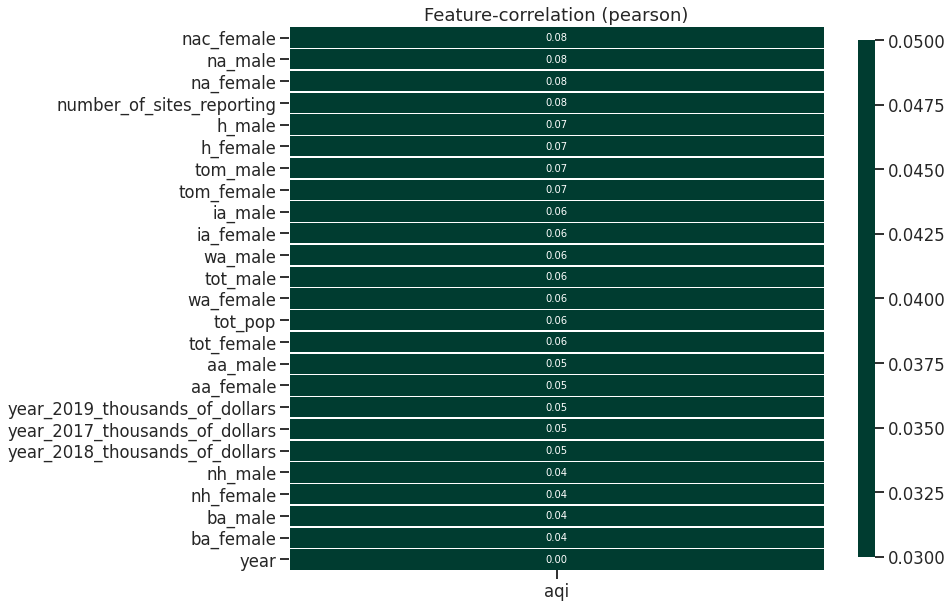

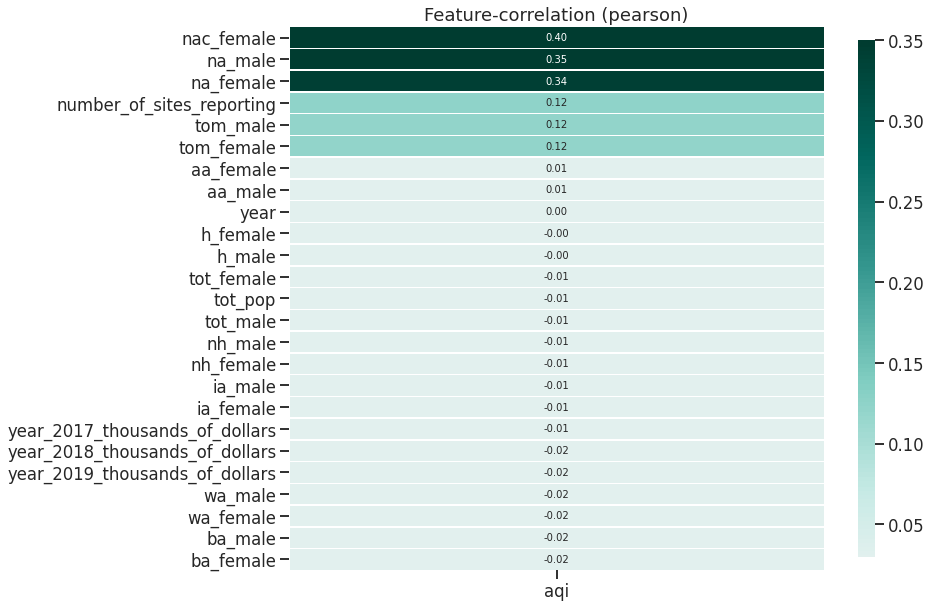

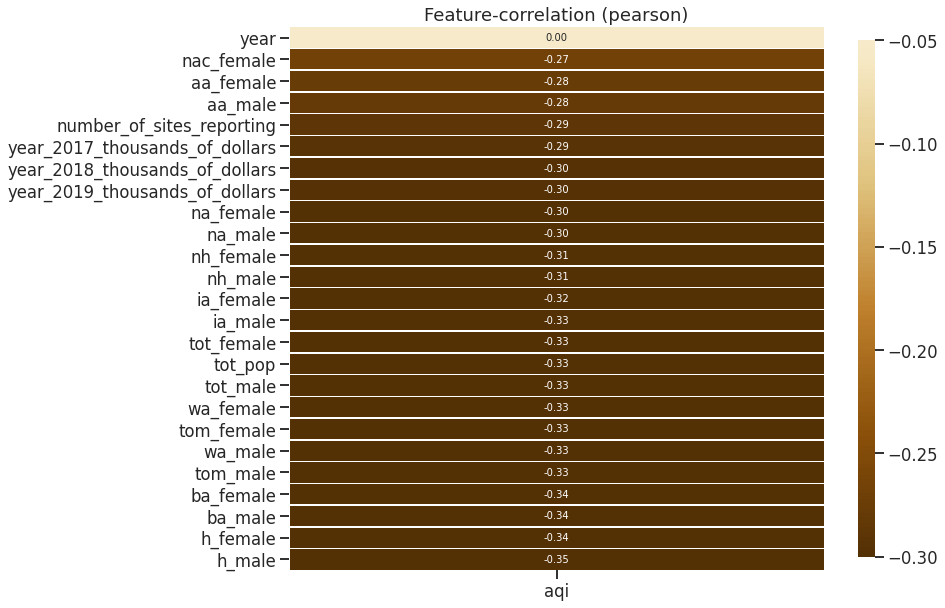

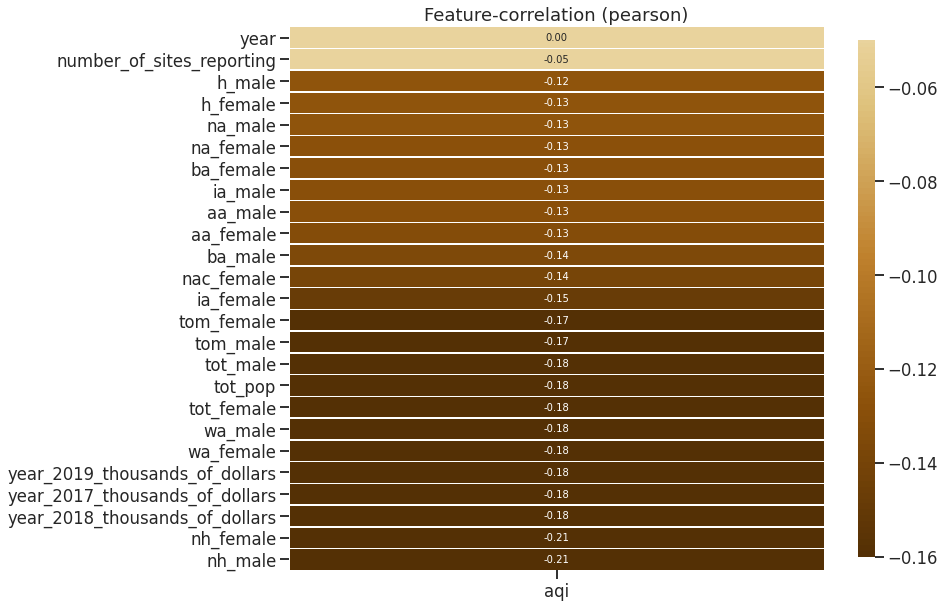

In [107]:
klib.corr_plot(good_df, target='aqi')
klib.corr_plot(moderate_df, target='aqi')
klib.corr_plot(unhealthy_for_sensitive_df, target='aqi')
klib.corr_plot(unhealthy_df, target='aqi')
klib.corr_plot(very_unhealthy_df, target='aqi')
klib.corr_plot(hazardous_df, target='aqi')

# when looking at segments of bad category it seems there is little correlation but still not strong correlation

shows that there is some correlation among unhealthy 
* highest correlation for native hawain other pacific islander alone or in comboination female .45
* second higest native hawaiian and other pacific islander alone male pop second highest

very unhealthy
* negative correlation with histpanic female and male pop -.3

hazardous
* negative correlation with non hispanic female and male pop

perhaps need to alter data to have ratios instead or work with different features

look at data from scatterplots

In [108]:
# county_daily_aqi_by_2017_2019['AQI'] = pd.to_numeric(county_daily_aqi_by_2017_2019.AQI)
# max = county_daily_aqi_by_2017_2019.AQI.max()
# county_daily_aqi_by_2017_2019.loc[max]
# haz = county_daily_aqi_by_2017_2019.Category == 'Hazardous'
# county_daily_aqi_by_2017_2019.loc[haz].max()
# county_daily_aqi_by_2017_2019.loc[haz]
# tar = df_cleaned.geo_fips == '80002'
# df_cleaned.loc[tar]

,geo_fips,region,state_name,county_name,year_2017_thousands_of_dollars,year_2018_thousands_of_dollars,year_2019_thousands_of_dollars,year,tot_pop,tot_male,...,nh_male,nh_female,h_male,h_female,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
207887,06051,8,California,Mono,732265.0,726449.0,772750.0,10,14354,7614,...,5553,4869,2061,1871,2017-04-06,3439,Hazardous,PM10,06-051-0011,2
208578,06051,8,California,Mono,732265.0,726449.0,772750.0,10,14354,7614,...,5553,4869,2061,1871,2019-02-26,3323,Hazardous,PM10,06-051-0011,3
208656,06051,8,California,Mono,732265.0,726449.0,772750.0,10,14354,7614,...,5553,4869,2061,1871,2019-05-15,3852,Hazardous,PM10,06-051-0011,4
208982,06051,8,California,Mono,732265.0,726449.0,772750.0,11,14403,7635,...,5575,4919,2060,1849,2017-04-06,3439,Hazardous,PM10,06-051-0011,2
209673,06051,8,California,Mono,732265.0,726449.0,772750.0,11,14403,7635,...,5575,4919,2060,1849,2019-02-26,3323,Hazardous,PM10,06-051-0011,3
209751,06051,8,California,Mono,732265.0,726449.0,772750.0,11,14403,7635,...,5575,4919,2060,1849,2019-05-15,3852,Hazardous,PM10,06-051-0011,4
210077,06051,8,California,Mono,732265.0,726449.0,772750.0,12,14444,7658,...,5617,4952,2041,1834,2017-04-06,3439,Hazardous,PM10,06-051-0011,2
210768,06051,8,California,Mono,732265.0,726449.0,772750.0,12,14444,7658,...,5617,4952,2041,1834,2019-02-26,3323,Hazardous,PM10,06-051-0011,3
210846,06051,8,California,Mono,732265.0,726449.0,772750.0,12,14444,7658,...,5617,4952,2041,1834,2019-05-15,3852,Hazardous,PM10,06-051-0011,4


save data for more cleaning


In [ ]:
# save the data to a new csv file. keep commented to prevent from always saving

# data_path = r'../../data/processed/clean_county_2017_2019.csv'
# df_cleaned.to_csv(data_path)